Загрузка данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

In [ ]:
try:
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')
    print("Данные успешно загружены")
except FileNotFoundError:
    print("Файлы не найдены. Используем демонстрационные данные")
    # Демо данные для примера
    from sklearn.datasets import fetch_california_housing
    data = fetch_california_housing()
    train_df = pd.DataFrame(data.data, columns=data.feature_names)
    train_df['target'] = data.target
    test_df = train_df.sample(frac=0.2)
    train_df = train_df.drop(test_df.index)

Данные успешно загружены


Исследование данных

АНАЛИЗ ДАННЫХ
ТРЕНИРОВОЧНЫЕ ДАННЫЕ:
Размер: (1460, 81)
Первые 5 строк:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12  

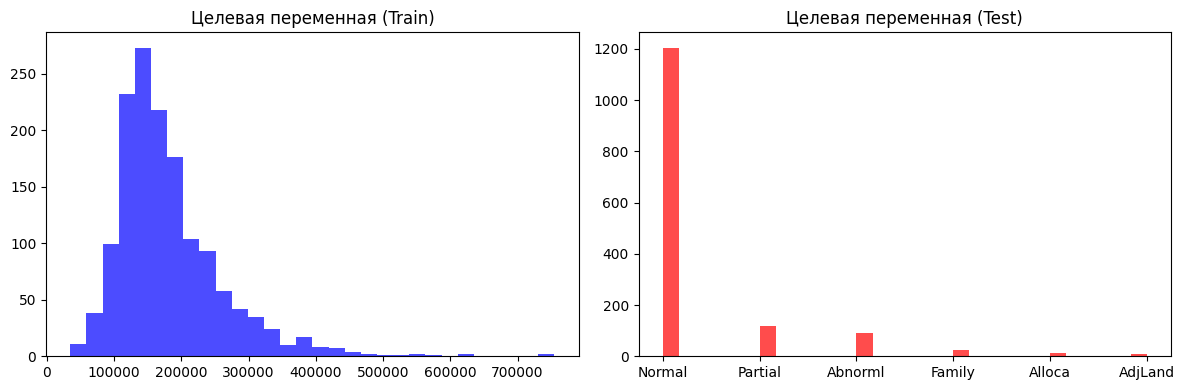

In [ ]:
print("=" * 50)
print("АНАЛИЗ ДАННЫХ")
print("=" * 50)

print("ТРЕНИРОВОЧНЫЕ ДАННЫЕ:")
print(f"Размер: {train_df.shape}")
print("Первые 5 строк:"); print(train_df.head())
print("Последние 5 строк:"); print(train_df.tail())
print("Информация:"); train_df.info()
print("Статистика:"); print(train_df.describe())
print(f"Пропуски: {train_df.isnull().sum().sum()}, Дубликаты: {train_df.duplicated().sum()}")

print("\nТЕСТОВЫЕ ДАННЫЕ:")
print(f"Размер: {test_df.shape}")
print("Первые 5 строк:"); print(test_df.head())
print("Последние 5 строк:"); print(test_df.tail())
print("Информация:"); test_df.info()
print("Статистика:"); print(test_df.describe())
print(f"Пропуски: {test_df.isnull().sum().sum()}, Дубликаты: {test_df.duplicated().sum()}")

# Визуализация
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(train_df.iloc[:, -1], bins=30, alpha=0.7, color='blue')
plt.title('Целевая переменная (Train)')
plt.subplot(1, 2, 2)
plt.hist(test_df.iloc[:, -1], bins=30, alpha=0.7, color='red')
plt.title('Целевая переменная (Test)')
plt.tight_layout(); plt.show()

Предобработка данных

In [ ]:
# 4. ПРЕДОБРАБОТКА ДАННЫХ
print("\n" + "=" * 50)
print("ПРЕДОБРАБОТКА ДАННЫХ")
print("=" * 50)

# Разделение данных
X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1]
X_test = test_df.iloc[:, :-1]
y_test = test_df.iloc[:, -1]

# Удаление дубликатов
X_train = X_train.drop_duplicates()
X_test = X_test.drop_duplicates()
y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]

print(f"После удаления дубликатов: X_train {X_train.shape}, X_test {X_test.shape}")

# Анализ колонок перед обработкой
print("\nОбщие колонки до обработки:")
common_cols_before = set(X_train.columns) & set(X_test.columns)
print(f"Общих колонок: {len(common_cols_before)}")

# Обработка пропусков
numeric_cols = X_train.select_dtypes(include=[np.number]).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

print(f"\nЧисловых колонок: {len(numeric_cols)}")
print(f"Категориальных колонок: {len(categorical_cols)}")

common_numeric = list(set(numeric_cols) & set(X_test.columns))
common_categorical = list(set(categorical_cols) & set(X_test.columns))

for col in common_numeric:
    if col in X_train.columns and col in X_test.columns:
        median_val = X_train[col].median()
        X_train[col] = X_train[col].fillna(median_val)
        X_test[col] = X_test[col].fillna(median_val)

for col in common_categorical:
    if col in X_train.columns and col in X_test.columns:
        mode_val = X_train[col].mode()[0] if len(X_train[col].mode()) > 0 else 'Unknown'
        X_train[col] = X_train[col].fillna(mode_val)
        X_test[col] = X_test[col].fillna(mode_val)

# Кодирование категориальных признаков
print("\nКодирование категориальных признаков...")

for col in common_categorical:
    if col in X_train.columns and col in X_test.columns:
        le = LabelEncoder()
        all_categories = pd.concat([X_train[col], X_test[col]], axis=0).unique()
        le.fit(all_categories)
        X_train[col] = le.transform(X_train[col])
        X_test[col] = le.transform(X_test[col])

# Выбираем только общие колонки
final_columns = list(set(X_train.columns) & set(X_test.columns))
print(f"Общих колонок после обработки: {len(final_columns)}")

X_train_final = X_train[final_columns]
X_test_final = X_test[final_columns]

# УДАЛЕНИЕ КОРРЕЛИРУЮЩИХ ПРИЗНАКОВ
print("\n" + "-" * 40)
print("УДАЛЕНИЕ КОРРЕЛИРУЮЩИХ ПРИЗНАКОВ")
print("-" * 40)

# Создаем копии перед удалением коррелирующих признаков
X_train_corr = X_train_final.copy()
X_test_corr = X_test_final.copy()

# Выбираем только числовые колонки для анализа корреляции
numeric_cols_for_corr = X_train_corr.select_dtypes(include=[np.number]).columns

if len(numeric_cols_for_corr) > 1:
    # Считаем корреляционную матрицу
    corr_matrix = X_train_corr[numeric_cols_for_corr].corr().abs()

    # Находим высококоррелированные признаки
    upper_triangle = corr_matrix.where(np.triu(np.ones_like(corr_matrix, dtype=bool), k=1))
    high_corr_features = [column for column in upper_triangle.columns
                         if any(upper_triangle[column] > 0.8)]

    print(f"Найдено высококоррелированных признаков (>0.8): {len(high_corr_features)}")
    if high_corr_features:
        print("Высококоррелированные признаки для удаления:")
        for feature in high_corr_features:
            # Находим с какими признаками коррелирует
            corr_with = upper_triangle[feature][upper_triangle[feature] > 0.8]
            corr_pairs = [f"{col}({corr:.2f})" for col, corr in corr_with.items()]
            print(f"  {feature} коррелирует с: {', '.join(corr_pairs)}")

        # Удаляем высококоррелированные признаки
        X_train_final = X_train_final.drop(columns=high_corr_features)
        X_test_final = X_test_final.drop(columns=high_corr_features)
        print(f"Удалено {len(high_corr_features)} коррелирующих признаков")
    else:
        print("Высококоррелированные признаки не найдены")
else:
    print("Недостаточно числовых признаков для анализа корреляции")

print(f"После удаления коррелирующих признаков: X_train {X_train_final.shape}, X_test {X_test_final.shape}")

# Масштабирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_test_scaled = scaler.transform(X_test_final)

print(f"\n После обработки: X_train {X_train_scaled.shape}, X_test {X_test_scaled.shape}")
print("Предобработка завершена ")


ПРЕДОБРАБОТКА ДАННЫХ
После удаления дубликатов: X_train (1460, 80), X_test (1459, 79)

Общие колонки до обработки:
Общих колонок: 79

Числовых колонок: 37
Категориальных колонок: 43

Кодирование категориальных признаков...
Общих колонок после обработки: 79

----------------------------------------
УДАЛЕНИЕ КОРРЕЛИРУЮЩИХ ПРИЗНАКОВ
----------------------------------------
Найдено высококоррелированных признаков (>0.8): 4
Высококоррелированные признаки для удаления:
  Exterior2nd коррелирует с: Exterior1st(0.85)
  GarageCars коррелирует с: GarageArea(0.88)
  TotalBsmtSF коррелирует с: 1stFlrSF(0.82)
  GrLivArea коррелирует с: TotRmsAbvGrd(0.83)
Удалено 4 коррелирующих признаков
После удаления коррелирующих признаков: X_train (1460, 75), X_test (1459, 75)

 После обработки: X_train (1460, 75), X_test (1459, 75)
Предобработка завершена 


Построение нейронной сети

In [ ]:
print("\n" + "=" * 50)
print("ПОСТРОЕНИЕ НЕЙРОННОЙ СЕТИ")
print("=" * 50)

# Создание модели
def create_model(input_dim):
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)  # Выходной слой для регрессии
    ])

    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    return model

# Создание и вывод модели
model = create_model(X_train_scaled.shape[1])
print("Архитектура модели:")
model.summary()


ПОСТРОЕНИЕ НЕЙРОННОЙ СЕТИ
Архитектура модели:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,097 (78.50 KB)

 Trainable params: 20,097 (78.50 KB)

 Non-trainable params: 0 (0.00 B)

Обучение модели

In [ ]:
print("\n" + "=" * 50)
print("ОБУЧЕНИЕ МОДЕЛИ")
print("=" * 50)

# Callback для ранней остановки
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True
)

# Обучение
history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)


ОБУЧЕНИЕ МОДЕЛИ
Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 38952394752.0000 - mae: 181370.6875 - val_loss: 39910592512.0000 - val_mae: 182225.5781
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 39586873344.0000 - mae: 181185.8906 - val_loss: 39845167104.0000 - val_mae: 182081.1875
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 38570057728.0000 - mae: 180889.7656 - val_loss: 39499296768.0000 - val_mae: 181353.4219
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 37072027648.0000 - mae: 177721.6875 - val_loss: 38289203200.0000 - val_mae: 178824.1875
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 36519976960.0000 - mae: 176882.2656 - val_loss: 35258265600.0000 - val_mae: 172263.8125
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 33496381440.0000 - mae: 169190.9688 - val_loss: 29650567168.0000 - val_mae: 159020.6094
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 25220270080.0000 - mae: 148873.5625 - 

Визуализация процесса обучения

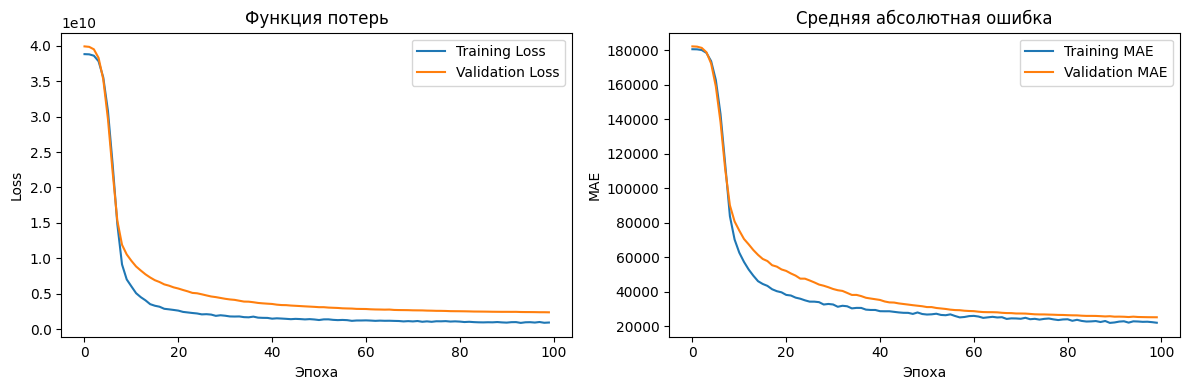

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Функция потерь')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Средняя абсолютная ошибка')
plt.xlabel('Эпоха')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

Оценка модели


ОЦЕНКА МОДЕЛИ
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Тип y_test: <class 'pandas.core.series.Series'>
Тип y_pred: <class 'numpy.ndarray'>
Уникальные значения в y_test: ['Normal' 'Partial' 'Abnorml' 'Family' 'Alloca' 'AdjLand']
Преобразуем целевую переменную в числовой формат...
y_test_encoded shape: (1459,)
y_pred shape: (1459,)
Результаты на тестовых данных:
Mean Squared Error (MSE): 37751058432.0000
Root Mean Squared Error (RMSE): 194296.3161
Mean Absolute Error (MAE): 175286.5469


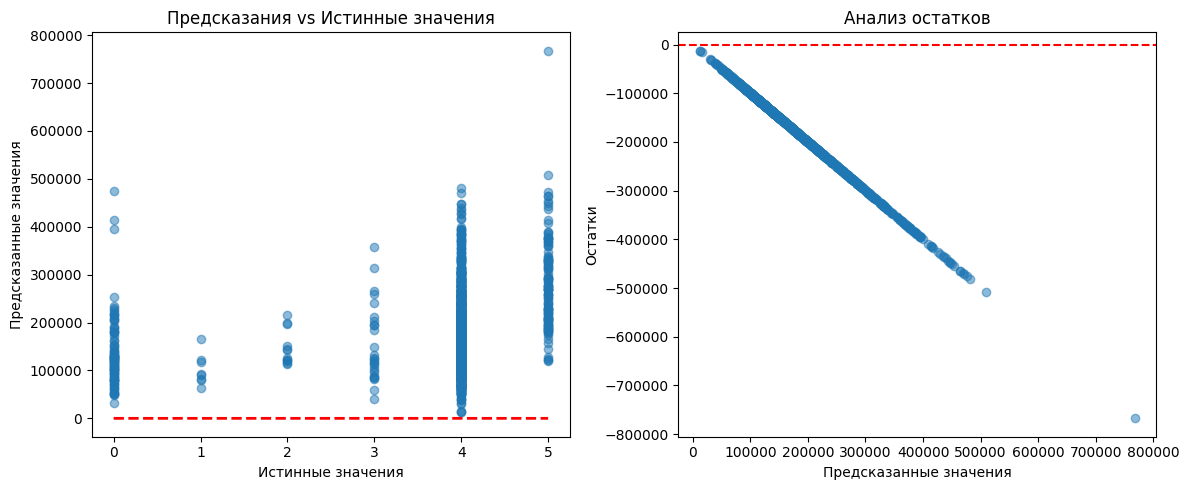


Распределение целевой переменной:
SaleCondition
Normal     1204
Partial     120
Abnorml      89
Family       26
Alloca       12
AdjLand       8
Name: count, dtype: int64


In [ ]:
print("\n" + "=" * 50)
print("ОЦЕНКА МОДЕЛИ")
print("=" * 50)

y_pred = model.predict(X_test_scaled).flatten()

print(f"Тип y_test: {type(y_test)}")
print(f"Тип y_pred: {type(y_pred)}")
print(f"Уникальные значения в y_test: {y_test.unique()[:10]}")

if y_test.dtype == 'object':
    print("Преобразуем целевую переменную в числовой формат...")
    le = LabelEncoder()
    y_test_encoded = le.fit_transform(y_test)
else:
    y_test_encoded = y_test.values

print(f"y_test_encoded shape: {y_test_encoded.shape}")
print(f"y_pred shape: {y_pred.shape}")

# Метрики
try:
    mse = mean_squared_error(y_test_encoded, y_pred)
    mae = mean_absolute_error(y_test_encoded, y_pred)
    rmse = np.sqrt(mse)

    print(f"Результаты на тестовых данных:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
except Exception as e:
    print(f"Ошибка при расчете метрик: {e}")

# Визуализация предсказаний
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test_encoded, y_pred, alpha=0.5)
plt.plot([y_test_encoded.min(), y_test_encoded.max()],
         [y_test_encoded.min(), y_test_encoded.max()], 'r--', lw=2)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('Предсказания vs Истинные значения')

plt.subplot(1, 2, 2)
residuals = y_test_encoded - y_pred
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('Анализ остатков')

plt.tight_layout()
plt.show()

# Дополнительная информация о распределении целевой переменной
print("\nРаспределение целевой переменной:")
if y_test.dtype == 'object':
    print(pd.Series(y_test).value_counts())
else:
    print(f"Min: {y_test.min():.2f}, Max: {y_test.max():.2f}, Mean: {y_test.mean():.2f}")

Анализ важности признаков


АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ
Количество признаков: 251
Размерность весов: (75, 128)
Количество важностей: 75
Несоответствие размеров: признаки 251, важности 75

Топ-10 важных признаков:
            feature  importance
51     LotShape_IR2    0.979174
66    LandSlope_Mod    0.976946
70  Condition1_Norm    0.934152
36         PoolArea    0.931778
29       GarageCars    0.896628
19        GrLivArea    0.784912
71  Condition1_PosA    0.739002
53     LotShape_Reg    0.664199
17         2ndFlrSF    0.616070
30       GarageArea    0.515220


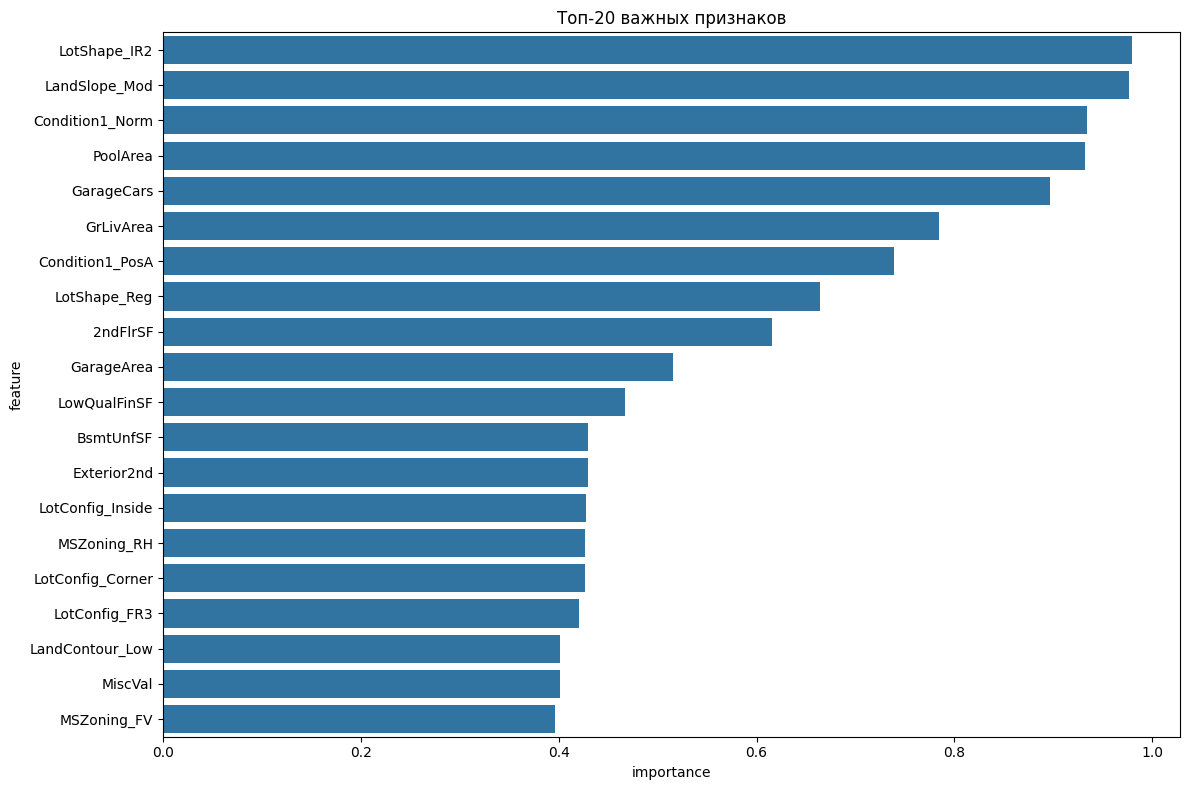

In [ ]:
print("\n" + "=" * 50)
print("АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ")
print("=" * 50)

# Получаем названия признаков после обработки
if 'X_train_processed' in locals() and hasattr(X_train_processed, 'columns'):
    feature_names = X_train_processed.columns.tolist()
elif 'X_train_numeric' in locals() and hasattr(X_train_numeric, 'columns'):
    feature_names = X_train_numeric.columns.tolist()
else:
    feature_names = X_train.select_dtypes(include=[np.number]).columns.tolist()

print(f"Количество признаков: {len(feature_names)}")

# Получение весов из модели
try:
    weights = model.layers[0].get_weights()[0]
    feature_importance = np.mean(np.abs(weights), axis=1)

    print(f"Размерность весов: {weights.shape}")
    print(f"Количество важностей: {len(feature_importance)}")

    if len(feature_importance) != len(feature_names):
        print(f"Несоответствие размеров: признаки {len(feature_names)}, важности {len(feature_importance)}")

        if len(feature_names) > len(feature_importance):
            feature_names = feature_names[:len(feature_importance)]
        else:
            feature_importance = feature_importance[:len(feature_names)]

    # Создание DataFrame для визуализации
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)

    print("\nТоп-10 важных признаков:")
    print(importance_df.head(10))

    # Визуализация важности признаков (топ-20)
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(20)
    sns.barplot(data=top_features, x='importance', y='feature')
    plt.title('Топ-20 важных признаков')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Ошибка при анализе важности признаков: {e}")
    print("Пропускаем анализ важности признаков")